In [9]:
# Chunk 1: Load Raw Text and BERT Embeddings
import pickle
import numpy as np
import os

with open('/ocean/projects/mth240012p/shared/data/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

embedding_dir = "bert_embeddings_frozen_delayed"
story_names = list(raw_text.keys())
delayed_embeddings = {s: np.load(f"{embedding_dir}/{s}.npy") for s in story_names}

/var/tmp/ipykernel_37494/1090494781.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


In [10]:
# Chunk 4: Prepare In-Memory Dataset for Fine-Tuning
import torch
from torch.utils.data import Dataset

class InMemoryBERTfMRIDataset(Dataset):
    def __init__(self, X_dict, raw_text, subject_dir):
        self.data = []
        for story, X in X_dict.items():
            y_path = os.path.join(subject_dir, f"{story}.npy")
            if not os.path.exists(y_path):
                continue

            Y = np.load(y_path)
            if X.shape[0] != Y.shape[0]:
                continue  # Skip misaligned

            self.data.append((X.astype(np.float32), Y.astype(np.float32)))

        print(f"Loaded {len(self.data)} valid story pairs")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, Y = self.data[idx]
        return {
            "X": torch.tensor(X),
            "Y": torch.tensor(Y)
        }


In [14]:
# Chunk 5: Fine-Tune BERT for fMRI Voxel Prediction Using In-Memory Data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Simple linear model to predict voxel activity from embeddings
class BERTToVoxels(nn.Module):
    def __init__(self, input_dim=3072, output_dim=94251):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )

    def forward(self, x):  # x: [T, input_dim]
        return self.model(x)  # [T, output_dim]

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTToVoxels(input_dim=3072, output_dim=94251).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Load data into DataLoader
subject2_dir = "/ocean/projects/mth240012p/shared/data/subject2"
train_dataset = InMemoryBERTfMRIDataset(delayed_embeddings, raw_text, subject2_dir)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader):
        X = batch["X"].squeeze(0).to(device)  # [T, 3072]
        Y = batch["Y"].squeeze(0).to(device)  # [T, 94251]

        # Check for NaNs/Infs
        if torch.isnan(Y).any() or torch.isinf(Y).any():
            print(f"Skipping batch with NaNs/Infs in Y")
            continue

        # Normalize inputs and targets
        X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-8)
        Y = (Y - Y.mean(dim=0)) / (Y.std(dim=0) + 1e-8)

        optimizer.zero_grad()
        preds = model(X)  # [T, 94251]
        loss = criterion(preds, Y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")



Loaded 101 valid story pairs


 20%|█▉        | 20/101 [00:01<00:05, 14.13it/s]

Skipping batch with NaNs/Infs in Y


 24%|██▍       | 24/101 [00:01<00:05, 14.60it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.05it/s]


Epoch 1, Avg Loss: 0.9850


 57%|█████▋    | 58/101 [00:04<00:03, 12.43it/s]

Skipping batch with NaNs/Infs in Y


 69%|██████▉   | 70/101 [00:05<00:02, 14.27it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.10it/s]


Epoch 2, Avg Loss: 0.9808


 28%|██▊       | 28/101 [00:02<00:05, 13.47it/s]

Skipping batch with NaNs/Infs in Y


 87%|████████▋ | 88/101 [00:06<00:00, 13.98it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.16it/s]


Epoch 3, Avg Loss: 0.9822


 23%|██▎       | 23/101 [00:01<00:06, 12.91it/s]

Skipping batch with NaNs/Infs in Y


 96%|█████████▌| 97/101 [00:07<00:00, 14.08it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.14it/s]


Epoch 4, Avg Loss: 0.9831


 79%|███████▉  | 80/101 [00:06<00:01, 15.05it/s]

Skipping batch with NaNs/Infs in Y
Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.16it/s]


Epoch 5, Avg Loss: 0.9844


 62%|██████▏   | 63/101 [00:04<00:02, 13.78it/s]

Skipping batch with NaNs/Infs in Y


 70%|███████   | 71/101 [00:05<00:02, 13.14it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.06it/s]


Epoch 6, Avg Loss: 0.9853


 64%|██████▍   | 65/101 [00:05<00:02, 12.75it/s]

Skipping batch with NaNs/Infs in Y


 80%|████████  | 81/101 [00:06<00:01, 14.86it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.07it/s]


Epoch 7, Avg Loss: 0.9855


 54%|█████▍    | 55/101 [00:04<00:03, 13.88it/s]

Skipping batch with NaNs/Infs in Y


 88%|████████▊ | 89/101 [00:06<00:00, 13.28it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.04it/s]


Epoch 8, Avg Loss: 0.9856


 36%|███▌      | 36/101 [00:02<00:05, 11.90it/s]

Skipping batch with NaNs/Infs in Y


 69%|██████▉   | 70/101 [00:05<00:02, 14.14it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.10it/s]


Epoch 9, Avg Loss: 0.9837


 65%|██████▌   | 66/101 [00:05<00:02, 14.20it/s]

Skipping batch with NaNs/Infs in Y


 93%|█████████▎| 94/101 [00:07<00:00, 13.45it/s]

Skipping batch with NaNs/Infs in Y


100%|██████████| 101/101 [00:07<00:00, 13.11it/s]

Epoch 10, Avg Loss: 0.9818


Loaded 20 valid story pairs


 85%|████████▌ | 17/20 [04:58<00:52, 17.49s/it]

Skipping test batch with NaNs/Infs


100%|██████████| 20/20 [05:34<00:00, 16.70s/it]


Evaluation — BERT Fine-Tuned Model (subject2):
Mean CC:   0.0239
Median CC: 0.0227
Top 1% CC: 0.0850
Top 5% CC: 0.0594


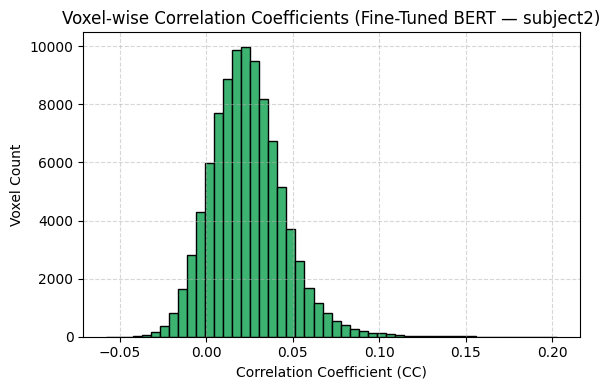

In [15]:
# Chunk 6:  Evaluate + Plot Voxel-Wise CCs for Subject 2
import scipy.stats as stats
import matplotlib.pyplot as plt

# Split stories into train/test sets (80/20 split)
story_names = list(delayed_embeddings.keys())
n_train = int(0.8 * len(story_names))
train_stories = story_names[:n_train]
test_stories = story_names[n_train:]

# Build test dataset
test_dataset = InMemoryBERTfMRIDataset(
    {k: delayed_embeddings[k] for k in test_stories},
    raw_text,
    subject2_dir
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
model.eval()
all_corrs = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        X = batch["X"].squeeze(0).to(device)
        Y = batch["Y"].squeeze(0).to(device)

        if torch.isnan(Y).any() or torch.isinf(Y).any():
            print("Skipping test batch with NaNs/Infs")
            continue

        preds = model(X)
        preds = preds.cpu().numpy()
        targets = Y.cpu().numpy()

        # Compute voxel-wise Pearson correlation
        corr = np.array([
            stats.pearsonr(preds[:, v], targets[:, v])[0]
            for v in range(targets.shape[1])
        ])

        all_corrs.append(corr)

# Stack and average
all_corrs = np.stack(all_corrs)
voxel_corrs = np.nanmean(all_corrs, axis=0)  # mean across test stories

# Print summary
print(f"\nEvaluation — BERT Fine-Tuned Model (subject2):")
print(f"Mean CC:   {np.mean(voxel_corrs):.4f}")
print(f"Median CC: {np.median(voxel_corrs):.4f}")
print(f"Top 1% CC: {np.percentile(voxel_corrs, 99):.4f}")
print(f"Top 5% CC: {np.percentile(voxel_corrs, 95):.4f}")

# Plot histogram of voxel-wise correlations
plt.figure(figsize=(6, 4))
plt.hist(voxel_corrs, bins=50, color="mediumseagreen", edgecolor="black")
plt.title("Voxel-wise Correlation Coefficients (Fine-Tuned BERT — subject2)")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Voxel Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Loaded 81 valid story pairs


100%|██████████| 81/81 [00:06<00:00, 12.58it/s]


Epoch 1, Avg Loss: 1.0058


100%|██████████| 81/81 [00:06<00:00, 12.59it/s]


Epoch 2, Avg Loss: 1.0014


100%|██████████| 81/81 [00:06<00:00, 12.63it/s]


Epoch 3, Avg Loss: 1.0016


100%|██████████| 81/81 [00:06<00:00, 12.56it/s]


Epoch 4, Avg Loss: 1.0014


100%|██████████| 81/81 [00:06<00:00, 12.54it/s]


Epoch 5, Avg Loss: 1.0018


100%|██████████| 81/81 [00:06<00:00, 12.67it/s]


Epoch 6, Avg Loss: 1.0032


100%|██████████| 81/81 [00:06<00:00, 12.67it/s]


Epoch 7, Avg Loss: 1.0037


100%|██████████| 81/81 [00:06<00:00, 12.68it/s]


Epoch 8, Avg Loss: 1.0051


100%|██████████| 81/81 [00:06<00:00, 12.62it/s]


Epoch 9, Avg Loss: 1.0052


100%|██████████| 81/81 [00:06<00:00, 12.58it/s]


Epoch 10, Avg Loss: 1.0044
Loaded 20 valid story pairs


  0%|          | 0/20 [00:00<?, ?it/s]/var/tmp/ipykernel_37494/2406320431.py:101: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  stats.pearsonr(preds[:, v], targets[:, v])[0]
 45%|████▌     | 9/20 [02:38<03:13, 17.58s/it]/var/tmp/ipykernel_37494/2406320431.py:101: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats.pearsonr(preds[:, v], targets[:, v])[0]
100%|██████████| 20/20 [05:55<00:00, 17.77s/it]


Evaluation — BERT Fine-Tuned Model (subject3):
Mean CC:   0.0180
Median CC: 0.0169
Top 1% CC: 0.0779
Top 5% CC: 0.0493


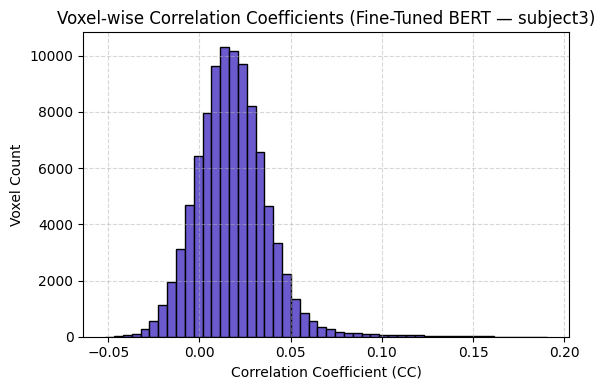

In [17]:
# Chunk 7: Fine-Tune and Evaluate BERT on Subject 3
import os
import torch
import torch.nn as nn
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

# Model
class BERTToVoxels(nn.Module):
    def __init__(self, input_dim=3072, output_dim=95556):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )

    def forward(self, x):  # [T, input_dim]
        return self.model(x)  # [T, output_dim]

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
subject3_dir = "/ocean/projects/mth240012p/shared/data/subject3"
output_dim = 95556  # based on subject3 voxel count

model = BERTToVoxels(input_dim=3072, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader (Train)
story_names = list(delayed_embeddings.keys())
n_train = int(0.8 * len(story_names))
train_stories = story_names[:n_train]

train_dataset = InMemoryBERTfMRIDataset(
    {k: delayed_embeddings[k] for k in train_stories},
    raw_text,
    subject3_dir
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Training
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader):
        X = batch["X"].squeeze(0).to(device)
        Y = batch["Y"].squeeze(0).to(device)

        if torch.isnan(Y).any() or torch.isinf(Y).any():
            print("Skipping batch with NaNs/Infs in Y")
            continue

        X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-8)
        Y = (Y - Y.mean(dim=0)) / (Y.std(dim=0) + 1e-8)

        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

# DataLoader (Eval)
test_stories = story_names[n_train:]
test_dataset = InMemoryBERTfMRIDataset(
    {k: delayed_embeddings[k] for k in test_stories},
    raw_text,
    subject3_dir
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluation
model.eval()
all_corrs = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        X = batch["X"].squeeze(0).to(device)
        Y = batch["Y"].squeeze(0).to(device)

        if torch.isnan(Y).any() or torch.isinf(Y).any():
            print("Skipping test batch with NaNs/Infs")
            continue

        preds = model(X)
        preds = preds.cpu().numpy()
        targets = Y.cpu().numpy()

        corr = np.array([
            stats.pearsonr(preds[:, v], targets[:, v])[0]
            for v in range(targets.shape[1])
        ])
        all_corrs.append(corr)

# Summary and Plot
all_corrs = np.stack(all_corrs)
voxel_corrs = np.nanmean(all_corrs, axis=0)

print(f"\nEvaluation — BERT Fine-Tuned Model (subject3):")
print(f"Mean CC:   {np.mean(voxel_corrs):.4f}")
print(f"Median CC: {np.median(voxel_corrs):.4f}")
print(f"Top 1% CC: {np.percentile(voxel_corrs, 99):.4f}")
print(f"Top 5% CC: {np.percentile(voxel_corrs, 95):.4f}")

plt.figure(figsize=(6, 4))
plt.hist(voxel_corrs, bins=50, color="slateblue", edgecolor="black")
plt.title("Voxel-wise Correlation Coefficients (Fine-Tuned BERT — subject3)")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Voxel Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
